# # Analysis of Protein Expression in Control and Down Syndrome Mice
# This notebook analyzes a dataset containing protein expression levels in the cerebral cortex of mice. The goal is to understand the effects of genotype, behavior, and drug treatment (Memantine vs. Saline) on these protein levels.
#
# The analysis addresses the following questions:
# 1. Study and describe the data. Do you see indications of potential issues when statistically modeling the data?
# 2. Train and compare LASSO, GAM, and a boosting model to separate Memantine from Saline treated samples. Interpret the results, discussing correlations, over-learning, non-linear effects, and interactions.
# 3. Evaluate if Memantine treatment induces any specific changes in protein levels of trisomic mice who were stimulated to learn.


## 0. Setup and Data Loading

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV # For LASSO
from pygam import LogisticGAM, s # For GAM
from sklearn.ensemble import GradientBoostingClassifier # For Boosting
from sklearn.metrics import roc_auc_score
from sklearn.inspection import PartialDependenceDisplay
from scipy.stats import ttest_ind # For t-tests
import statsmodels.stats.multitest as smm # For FDR correction
from sklearn.decomposition import PCA # For PCA

In [5]:
# Set plotting style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Load the dataset
# This assumes 'Cortex3.csv' is in the same directory as the notebook.
# If not, please adjust the path.
try:
    df = pd.read_csv("Assignment/Cortex3.csv")
except FileNotFoundError:
    print("Error: Cortex3.csv not found. Please ensure the file is in the correct directory.")
    raise

print("Data Shape (samples, columns):", df.shape)
print("\nFirst 5 rows of the data:")
print(df.head())

# Identify protein columns (ending with '_N') and categorical/metadata columns
protein_cols = [col for col in df.columns if col.endswith('_N')]
metadata_cols = ['Genotype', 'Treatment', 'Behavior']
print(f"\nFound {len(protein_cols)} protein expression columns.")
print(f"Found {len(metadata_cols)} metadata columns: {metadata_cols}")

Data Shape (samples, columns): (70, 73)

First 5 rows of the data:
   DYRK1A_N   ITSN1_N    BDNF_N     NR1_N    NR2A_N    pAKT_N   pBRAF_N  \
0  0.427989  0.611945  0.316096  2.057295  3.450930  0.288470  0.179682   
1  0.274969  0.538051  0.321415  2.350008  3.681566  0.277864  0.195006   
2  0.318280  0.471401  0.324946  2.585867  4.048926  0.264531  0.207836   
3  0.413631  0.579576  0.345870  2.360047  4.544935  0.225490  0.212180   
4  0.602479  0.663114  0.371800  2.369098  4.433458  0.244078  0.215207   

   pCAMKII_N   pCREB_N    pELK_N  ...    SNCA_N  Ubiquitin_N  pGSK3B_Tyr216_N  \
0   2.539125  0.192975  1.556223  ...  0.192071     1.319323         0.739725   
1   2.809781  0.258243  1.183554  ...  0.155201     1.379009         0.782226   
2   3.697912  0.241246  1.357533  ...  0.196178     1.451962         0.877407   
3   2.677465  0.202960  1.427544  ...  0.110186     0.958435         0.820530   
4   2.669999  0.165503  1.875758  ...  0.150344     1.084034         0.664749

## 1. Study and Describe the Data
This section explores the dataset to understand its structure, identify potential issues, and prepare for statistical modeling.


### 1.1. Initial Data Inspection

In [6]:
# Check for missing values
print("Missing values per column (showing columns with any missing values):")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])
if missing_values.sum() == 0:
    print("No missing values found in the dataset.")

# Check data types
print("\nData types summary:")
print(df.dtypes.value_counts())
print("\nData types of metadata columns:")
print(df[metadata_cols].dtypes)
print("\nData types of first 3 protein columns:")
print(df[protein_cols[:3]].dtypes)

# Convert categorical columns from 'object' to 'category' type for efficiency and semantic correctness.
for col in metadata_cols:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')
print("\nData types of metadata columns after potential conversion:")
print(df[metadata_cols].dtypes)

Missing values per column (showing columns with any missing values):
Series([], dtype: int64)
No missing values found in the dataset.

Data types summary:
float64    70
object      3
Name: count, dtype: int64

Data types of metadata columns:
Genotype     object
Treatment    object
Behavior     object
dtype: object

Data types of first 3 protein columns:
DYRK1A_N    float64
ITSN1_N     float64
BDNF_N      float64
dtype: object

Data types of metadata columns after potential conversion:
Genotype     category
Treatment    category
Behavior     category
dtype: object


### 1.2. Descriptive Statistics

In [7]:
# Summary statistics for numerical (protein) columns
print("Summary statistics for protein expression levels (first 5 proteins):")
print(df[protein_cols].describe().transpose().head())

# Value counts for categorical columns
print("\nDistribution of samples across Genotype:")
print(df['Genotype'].value_counts())
print("\nDistribution of samples across Treatment:")
print(df['Treatment'].value_counts())
print("\nDistribution of samples across Behavior:")
print(df['Behavior'].value_counts())

Summary statistics for protein expression levels (first 5 proteins):
          count      mean       std       min       25%       50%       75%  \
DYRK1A_N   70.0  0.428313  0.243243  0.179513  0.286172  0.378421  0.487118   
ITSN1_N    70.0  0.619427  0.234685  0.340665  0.497185  0.572216  0.681567   
BDNF_N     70.0  0.324609  0.037469  0.234985  0.300939  0.321284  0.349877   
NR1_N      70.0  2.340231  0.251004  1.714165  2.182133  2.364597  2.508762   
NR2A_N     70.0  3.947435  0.659236  2.486368  3.573663  3.943376  4.338222   

               max  
DYRK1A_N  2.048408  
ITSN1_N   2.113230  
BDNF_N    0.417596  
NR1_N     2.806805  
NR2A_N    5.720960  

Distribution of samples across Genotype:
Genotype
Control    36
Ts65Dn     34
Name: count, dtype: int64

Distribution of samples across Treatment:
Treatment
Memantine    38
Saline       32
Name: count, dtype: int64

Distribution of samples across Behavior:
Behavior
S/C    36
C/S    34
Name: count, dtype: int64


### 1.3. Visual Data Exploration

#### 1.3.1. Distribution of Protein Expression Levels

Histograms for the first 3 protein expression levels:


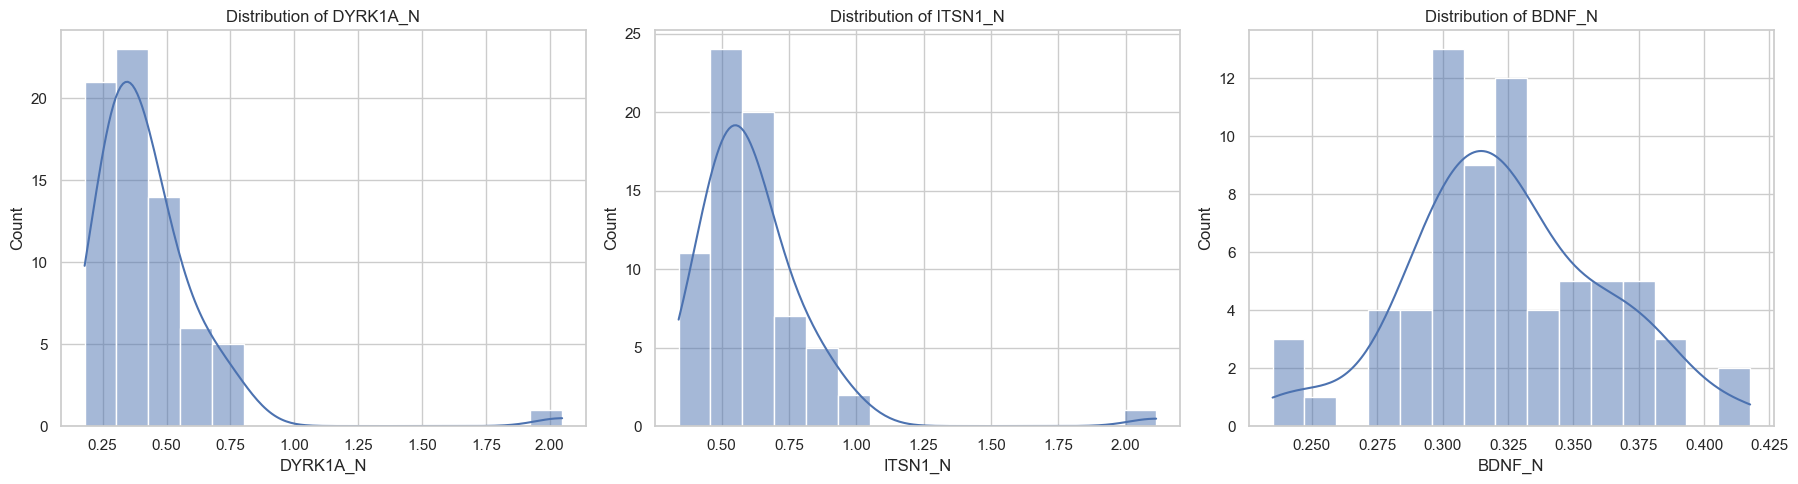


Boxplots for the first 3 protein expression levels by Treatment:


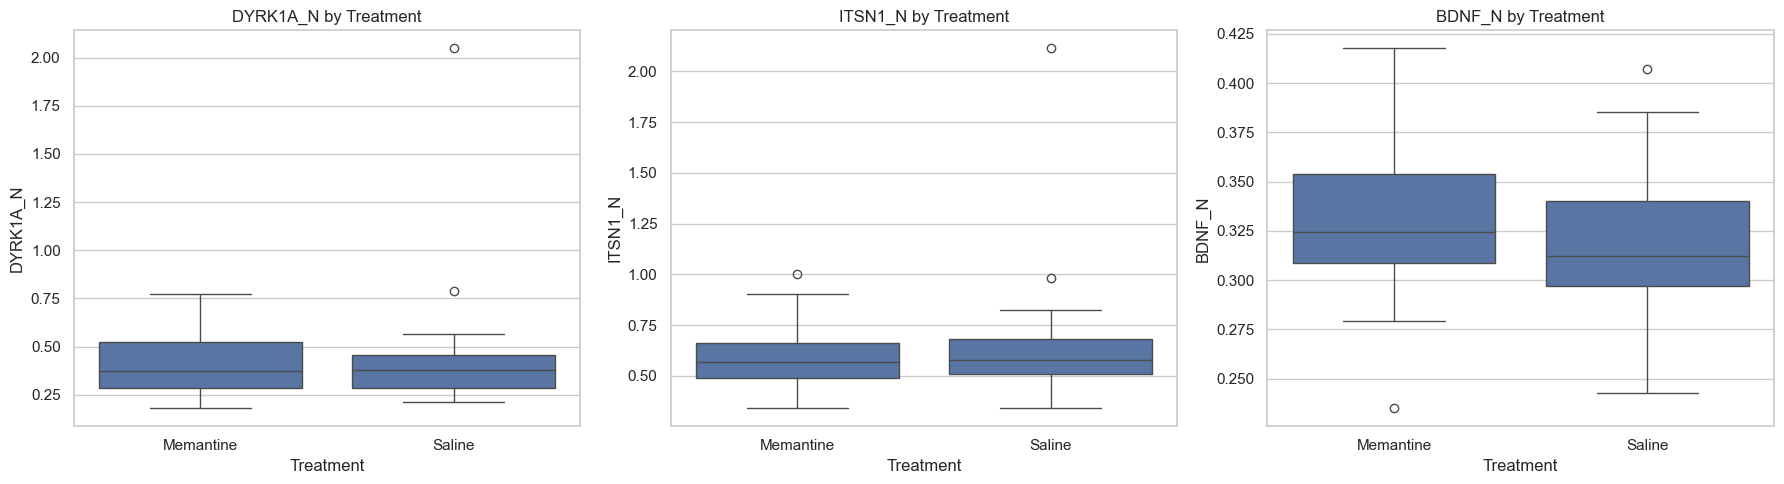

In [8]:
# Plot histograms for a few example protein expression levels
print("Histograms for the first 3 protein expression levels:")
plt.figure(figsize=(18, 5))
for i, col in enumerate(protein_cols[:3]): # Plot first 3 proteins
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col], kde=True, bins=15)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Boxplots for a few example proteins grouped by 'Treatment'
print("\nBoxplots for the first 3 protein expression levels by Treatment:")
plt.figure(figsize=(18, 5))
for i, col in enumerate(protein_cols[:3]):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='Treatment', y=col, data=df)
    plt.title(f'{col} by Treatment')
plt.tight_layout()
plt.show()

#### 1.3.2. Protein Expression Correlation Heatmap

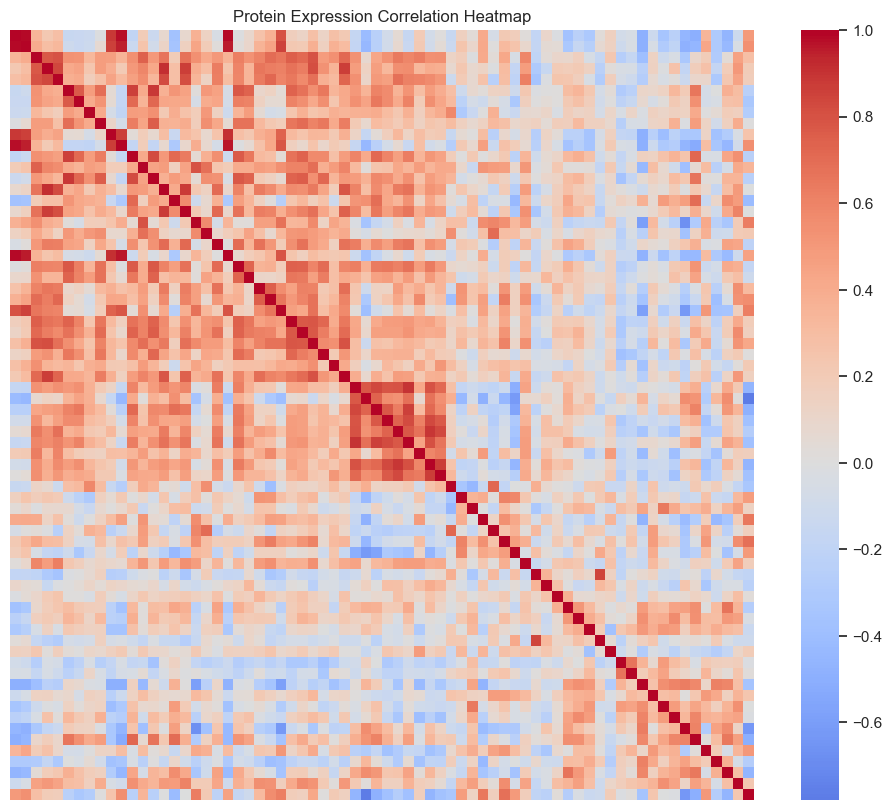

In [9]:
# Calculate and plot the correlation matrix for protein expression levels
corr_matrix = df[protein_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False, xticklabels=False, yticklabels=False)
plt.title("Protein Expression Correlation Heatmap")
plt.show()

#### 1.3.3. Principal Component Analysis (PCA)


Explained variance by PC1: 0.269
Explained variance by PC2: 0.176
Total explained variance by first 2 PCs: 0.445
Cumulative explained variance by first 10 PCs (or fewer if <10 features): [0.26883877 0.44503384 0.54644383 0.62235358 0.67176613 0.7161458
 0.75265764 0.78471681 0.80927326 0.82891753]


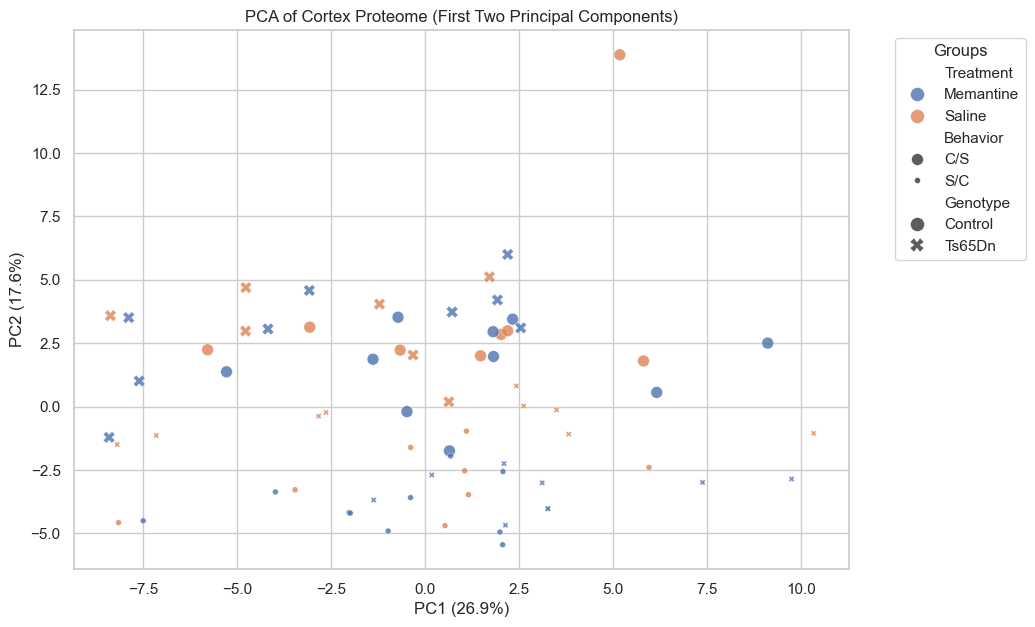

In [10]:
# Scale protein expression data before PCA
X_proteins_scaled = StandardScaler().fit_transform(df[protein_cols])

# Perform PCA
# Using enough components to explain a good portion of variance, e.g., 5-10, then visualize first 2.
pca_full = PCA(n_components=min(10, X_proteins_scaled.shape[1]))
pca_full.fit(X_proteins_scaled)

pca_2comp = PCA(n_components=2)
pcs_2comp = pca_2comp.fit_transform(X_proteins_scaled)
pc_df = pd.DataFrame(data=pcs_2comp, columns=['PC1', 'PC2'])
pc_df_combined = pd.concat([pc_df, df[metadata_cols].reset_index(drop=True)], axis=1) # reset_index if df index is not standard

print(f"\nExplained variance by PC1: {pca_2comp.explained_variance_ratio_[0]:.3f}")
print(f"Explained variance by PC2: {pca_2comp.explained_variance_ratio_[1]:.3f}")
print(f"Total explained variance by first 2 PCs: {np.sum(pca_2comp.explained_variance_ratio_):.3f}")
print(f"Cumulative explained variance by first 10 PCs (or fewer if <10 features): {np.cumsum(pca_full.explained_variance_ratio_)}")

plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='Treatment', style='Genotype', size='Behavior', data=pc_df_combined, s=100, alpha=0.8)
plt.title('PCA of Cortex Proteome (First Two Principal Components)')
plt.xlabel(f'PC1 ({pca_2comp.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca_2comp.explained_variance_ratio_[1]*100:.1f}%)')
plt.legend(title='Groups', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## 2. Train and Compare LASSO, GAM, and Boosting Models
This section focuses on training and comparing three different models (LASSO, GAM, Gradient Boosting) to classify samples based on their treatment (Memantine vs. Saline) using protein expression data. We will use 5-fold cross-validation to estimate the test error (AUC) for model comparison.


### 2.1. Data Preparation for Classification

In [11]:
# Define feature matrix X (protein expressions) and target y (Treatment)
X = df[protein_cols].values
# Encode 'Treatment' labels: Memantine=1, Saline=0
y = (df['Treatment'] == 'Memantine').astype(int)

label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['Saline', 'Memantine'])
print(f"Original Treatment labels: {df['Treatment'].unique()}")
print(f"Encoded Treatment labels: {np.unique(y)} maps to classes: {label_encoder.classes_}")

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
# This split is for an initial evaluation of models after parameter tuning (for LASSO)
# and for generating PDPs. The primary model comparison will use 5-fold CV on the full (scaled) dataset.
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)
print(f"\nX_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"Class distribution in y_train: Saline (0)={np.sum(y_train==0)}, Memantine (1)={np.sum(y_train==1)}")
print(f"Class distribution in y_test: Saline (0)={np.sum(y_test==0)}, Memantine (1)={np.sum(y_test==1)}")


Original Treatment labels: ['Saline', 'Memantine']
Categories (2, object): ['Memantine', 'Saline']
Encoded Treatment labels: [0 1] maps to classes: ['Saline' 'Memantine']

X_train shape: (49, 70), y_train shape: (49,)
X_test shape: (21, 70), y_test shape: (21,)
Class distribution in y_train: Saline (0)=22, Memantine (1)=27
Class distribution in y_test: Saline (0)=10, Memantine (1)=11


### 2.2. Model Training and Evaluation on Test Split


#### 2.2.1. LASSO (Logistic Regression with L1 penalty)

Best C for LASSO (from training data CV): 5.4556
LASSO Test AUC: 0.936

Number of features selected by LASSO: 28
Top 5 selected features by LASSO (absolute coefficient value):
pBRAF_N       3.583515
NR2A_N        2.981937
AKT_N         2.825257
Bcatenin_N    1.229388
GluR3_N       1.221958
dtype: float64


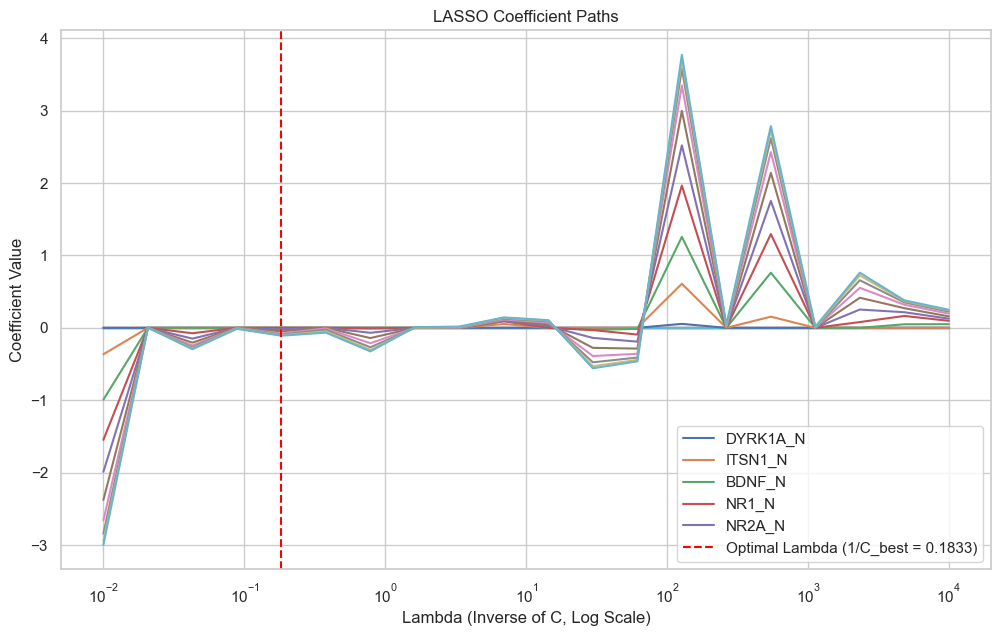

In [12]:
# Train a LASSO model. LogisticRegressionCV internally performs cross-validation
# to find the best regularization parameter C (inverse of lambda).
# The L1 penalty promotes sparsity, performing feature selection.
lasso_model_cv = LogisticRegressionCV(
    Cs=np.logspace(-4, 2, 20),  # Explore a range of C values
    cv=5,                      # 5-fold internal cross-validation for C
    penalty='l1',
    solver='saga',             # 'saga' or 'liblinear' are suitable for L1
    scoring='roc_auc',
    max_iter=10000,
    random_state=42,
    n_jobs=-1
)
lasso_model_cv.fit(X_train, y_train) # Fit on the training data to find best C

print(f"Best C for LASSO (from training data CV): {lasso_model_cv.C_[0]:.4f}")

# Evaluate on the held-out test set
y_prob_lasso_test = lasso_model_cv.predict_proba(X_test)[:, 1]
auc_lasso_test = roc_auc_score(y_test, y_prob_lasso_test)
print(f"LASSO Test AUC: {auc_lasso_test:.3f}")

# Inspect coefficients from the model trained with the best C
lasso_coeffs = pd.Series(lasso_model_cv.coef_[0], index=protein_cols)
selected_features_lasso = lasso_coeffs[lasso_coeffs != 0]
print(f"\nNumber of features selected by LASSO: {len(selected_features_lasso)}")
if len(selected_features_lasso) > 0:
    print("Top 5 selected features by LASSO (absolute coefficient value):")
    print(selected_features_lasso.abs().sort_values(ascending=False).head())
else:
    print("No features selected by LASSO with the chosen C values.")

# Plot coefficient paths for LogisticRegressionCV
# coefs_paths_ stores coefficients for each class, for each C, for each fold.
# For binary classification, coefs for class 1 are usually of interest.
coefs_path = lasso_model_cv.coefs_paths_[1]
if coefs_path.ndim == 3: # if per-fold paths are stored
    coefs_path_mean = np.mean(coefs_path, axis=0) # Average over folds
else: # if paths are for the model refit on full train data with best C for each C
    coefs_path_mean = coefs_path

plt.figure(figsize=(12, 7))
# LogisticRegressionCV uses Cs (inverse of lambda). Plot against 1/Cs for lambda-like behavior.
lambdas_lasso = 1. / lasso_model_cv.Cs_
sorted_lambda_indices = np.argsort(lambdas_lasso) # Sort for plotting
for i in range(coefs_path_mean.shape[0]):
    plt.plot(lambdas_lasso[sorted_lambda_indices], coefs_path_mean[i, sorted_lambda_indices], label=f'{protein_cols[i]}' if i < 5 else None) # Label first 5
plt.xscale('log')
plt.xlabel('Lambda (Inverse of C, Log Scale)')
plt.ylabel('Coefficient Value')
plt.title('LASSO Coefficient Paths')
plt.axvline(1./lasso_model_cv.C_[0], color='red', linestyle='--', label=f'Optimal Lambda (1/C_best = {1./lasso_model_cv.C_[0]:.4f})')
plt.legend()
plt.show()

#### 2.2.2. Generalized Additive Model (GAM)

In [13]:
# Train a GAM to capture potential non-linear relationships.
# Due to high dimensionality, features selected by LASSO are used for GAM.
if len(selected_features_lasso) == 0:
    print("LASSO selected 0 features. GAM training will be skipped.")
    gam_feature_indices_for_fit = []
    gam_feature_names_for_fit = []
    gam_model_fit = None
    auc_gam_test = np.nan
else:
    gam_feature_names_for_fit = selected_features_lasso.index.tolist()
    gam_feature_indices_for_fit = [protein_cols.index(name) for name in gam_feature_names_for_fit]

    print(f"\nGAM will be trained on {len(gam_feature_names_for_fit)} features selected by LASSO: {gam_feature_names_for_fit[:5]}...")

    # Construct terms for GAM: one spline term 's(i)' for each selected feature.
    gam_terms_fit = s(0)
    for i in range(1, len(gam_feature_names_for_fit)):
        gam_terms_fit += s(i)

    gam_model_fit = LogisticGAM(gam_terms_fit)
    gam_model_fit.fit(X_train[:, gam_feature_indices_for_fit], y_train)

    # Evaluate GAM on the test set
    y_prob_gam_test = gam_model_fit.predict_proba(X_test[:, gam_feature_indices_for_fit])
    auc_gam_test = roc_auc_score(y_test, y_prob_gam_test)
    print(f"GAM Test AUC (on LASSO-selected features): {auc_gam_test:.3f}")

    # check GAM summary for effective degrees of freedom (EDoF) of splines.
    # gam_model_fit.summary() 



GAM will be trained on 28 features selected by LASSO: ['BDNF_N', 'NR2A_N', 'pBRAF_N', 'pCAMKII_N', 'pCREB_N']...
GAM Test AUC (on LASSO-selected features): 0.445


#### 2.2.3. Gradient Boosting Machine (GBM)


Gradient Boosting Test AUC: 0.836


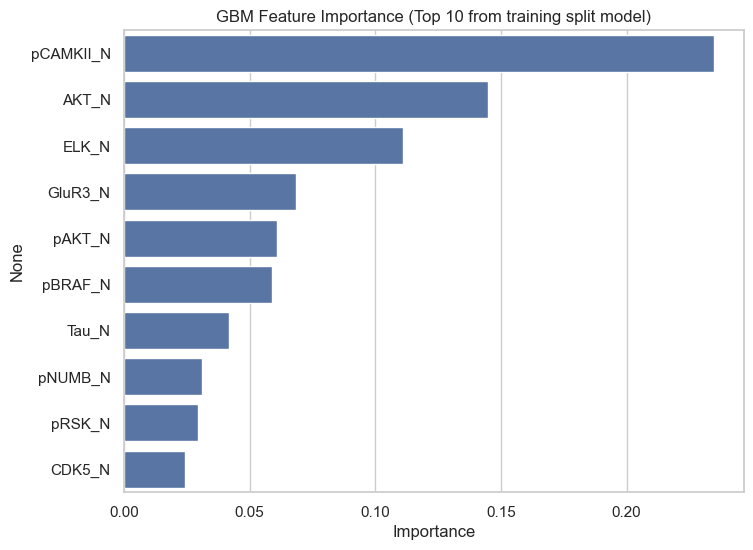

In [14]:
# Train a Gradient Boosting model, which can capture complex non-linear
# relationships and feature interactions.
gb_model_fit = GradientBoostingClassifier(random_state=42, n_estimators=100, max_depth=3, learning_rate=0.1)
# Note: n_estimators and other hyperparameters ideally should be tuned via CV (e.g., GridSearchCV).
# For this assignment, fixed reasonable values are used for initial evaluation.
gb_model_fit.fit(X_train, y_train)

# Evaluate on the test set
y_prob_gb_test = gb_model_fit.predict_proba(X_test)[:, 1]
auc_gb_test = roc_auc_score(y_test, y_prob_gb_test)
print(f"Gradient Boosting Test AUC: {auc_gb_test:.3f}")

# Feature importances
gb_importances = pd.Series(gb_model_fit.feature_importances_, index=protein_cols)
top10_gb_features = gb_importances.nlargest(10)
plt.figure(figsize=(8, 6))
sns.barplot(x=top10_gb_features.values, y=top10_gb_features.index)
plt.title('GBM Feature Importance (Top 10 from training split model)')
plt.xlabel('Importance')
plt.show()

### 2.3. Model Comparison using 5-Fold Cross-Validation AUC

LASSO 5-fold CV AUC: 0.893 ± 0.068
GAM (28 LASSO-selected features) 5-fold CV AUC: nan ± nan


c:\Users\robbe\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\robbe\miniconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\robbe\miniconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "c:\Users\robbe\miniconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\robbe\miniconda3\Lib\site-packages\sklearn\utils\_response.py", line 235, in _get_response_values
    raise ValueError(
ValueError: LogisticGAM should either be a classifier to be used with response_method=predict_proba or the response_method sh

Gradient Boosting 5-fold CV AUC: 0.760 ± 0.099
Note for GBM: n_estimators can be tuned, e.g., using gbm.perf in R or validation curves in Python.


C:\Users\robbe\AppData\Local\Temp\ipykernel_15828\903620529.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mean AUC', y='Model', data=cv_results_df, xerr=xerr, palette='viridis')


ValueError: 'xerr' (shape: (2,)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'x' (shape: (1,))

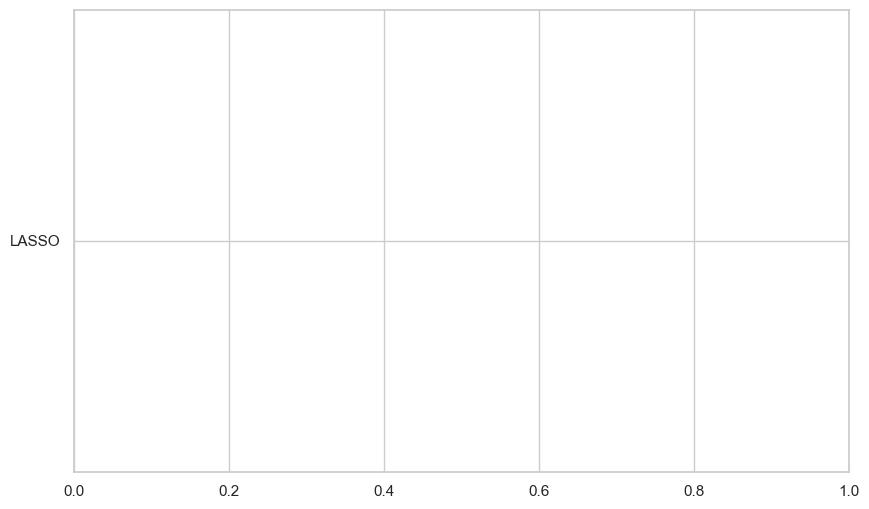

In [15]:
# More robustly compare the generalization performance of LASSO, GAM, and GBM.
# We use 5-fold stratified cross-validation on the entire scaled dataset (X_scaled, y)
# and report the mean and standard deviation of the AUC scores.
# Stratification helps ensure class proportions are similar across folds.

cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- LASSO CV ---
# For LASSO, we create a new LogisticRegressionCV instance to be used in cross_val_score.
# This ensures that for each fold of the outer CV, the hyperparameter C is tuned
# using an inner CV on that fold's training data. This is a more rigorous approach.
lasso_for_cv = LogisticRegressionCV(
    Cs=np.logspace(-4, 2, 20), cv=5, penalty='l1', solver='saga',
    scoring='roc_auc', max_iter=10000, random_state=123, n_jobs=-1
)
lasso_cv_scores = cross_val_score(lasso_for_cv, X_scaled, y, cv=cv_stratified, scoring='roc_auc', n_jobs=-1)
print(f"LASSO 5-fold CV AUC: {lasso_cv_scores.mean():.3f} \u00B1 {lasso_cv_scores.std():.3f}")

# --- GAM CV ---
# GAM CV is tricky if feature selection is part of the pipeline to be CV'd.
# For this assignment's scope, we will use the features selected once by LASSO on the initial training split.
# This means the feature set for GAM is fixed across folds of this CV.
# A fully rigorous approach would re-run LASSO feature selection in each fold.
if len(gam_feature_indices_for_fit) > 0:
    # We need to re-initialize the GAM model for each fold because it's stateful after fitting.
    # cross_val_score clones the estimator.
    gam_for_cv = LogisticGAM(gam_terms_fit) # Use terms based on initially selected features
    gam_cv_scores = cross_val_score(gam_for_cv, X_scaled[:, gam_feature_indices_for_fit], y, cv=cv_stratified, scoring='roc_auc')
    print(f"GAM ({len(gam_feature_names_for_fit)} LASSO-selected features) 5-fold CV AUC: {gam_cv_scores.mean():.3f} \u00B1 {gam_cv_scores.std():.3f}")
else:
    print("GAM not cross-validated as no features were selected by initial LASSO run.")
    gam_cv_scores = np.array([np.nan]) # Placeholder

# --- Gradient Boosting CV ---
# We use the same fixed hyperparameters for GBM as in the initial fit for consistency in this comparison.
# Ideally, GBM hyperparameters (like n_estimators, max_depth, learning_rate) would also be tuned
# within each fold of a nested CV, or a simpler CV to find one best set of HPs.
gb_for_cv = GradientBoostingClassifier(random_state=42, n_estimators=100, max_depth=3, learning_rate=0.1)
gb_cv_scores = cross_val_score(gb_for_cv, X_scaled, y, cv=cv_stratified, scoring='roc_auc', n_jobs=-1)
print(f"Gradient Boosting 5-fold CV AUC: {gb_cv_scores.mean():.3f} \u00B1 {gb_cv_scores.std():.3f}")
print("Note for GBM: n_estimators can be tuned, e.g., using gbm.perf in R or validation curves in Python.")

# Plot CV scores for comparison
plt.figure(figsize=(10, 6))
cv_results_df = pd.DataFrame({
    'Model': ['LASSO', 'GAM', 'Gradient Boosting'],
    'Mean AUC': [lasso_cv_scores.mean(), gam_cv_scores.mean(), gb_cv_scores.mean()],
    'Std AUC': [lasso_cv_scores.std(), gb_cv_scores.std() if not np.isnan(gam_cv_scores.mean()) else np.nan, gb_cv_scores.std()]
}).dropna().sort_values(by='Mean AUC', ascending=False)

xerr = cv_results_df['Std AUC'].values
sns.barplot(x='Mean AUC', y='Model', data=cv_results_df, xerr=xerr, palette='viridis')
plt.title('Model Comparison (5-Fold Stratified CV AUC)')
plt.xlabel('Mean Area Under ROC Curve (AUC)')
plt.ylabel('Model')
plt.xlim(0.5, 1.0) # Assuming AUC is between 0.5 (random) and 1.0 (perfect)

for idx, (mean_auc, std_auc) in enumerate(zip(cv_results_df['Mean AUC'], cv_results_df['Std AUC'])):
    plt.text(mean_auc + std_auc + 0.01, idx, f"{mean_auc:.3f}", color='black', ha="left", va='center')
plt.show()

# Store the best model from CV for later interpretation if needed
best_model_name = cv_results_df.iloc[0]['Model']
print(f"\nBest performing model based on mean CV AUC: {best_model_name}")


Partial Dependence (Spline) Plots for GAM (selected features):


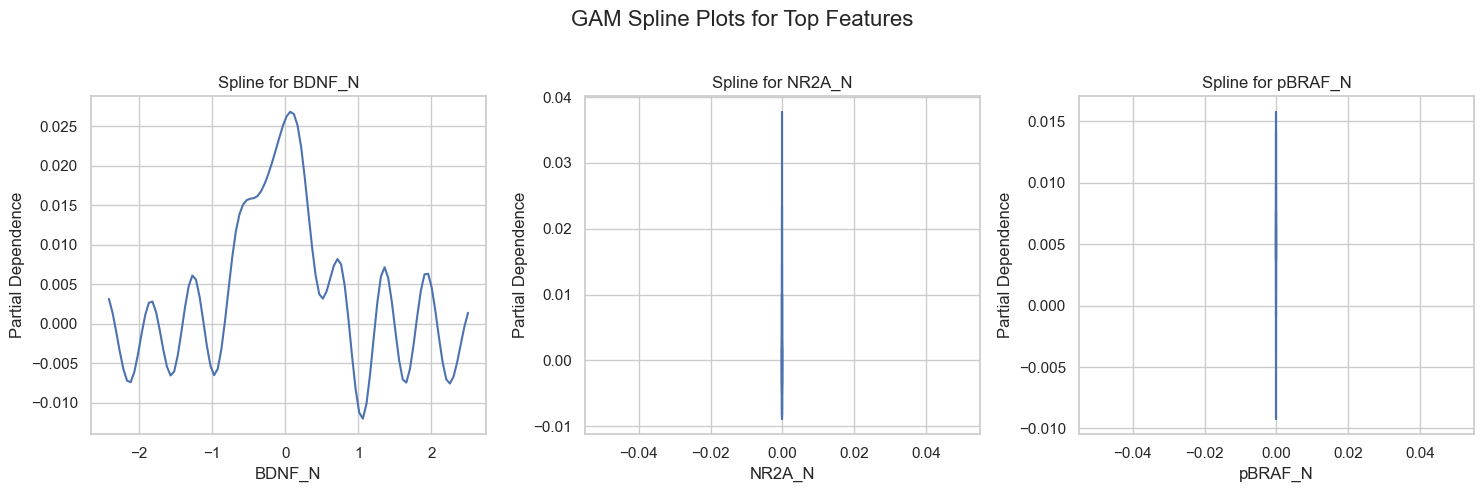


Partial Dependence Plots for Gradient Boosting (top 2 features from training split model):


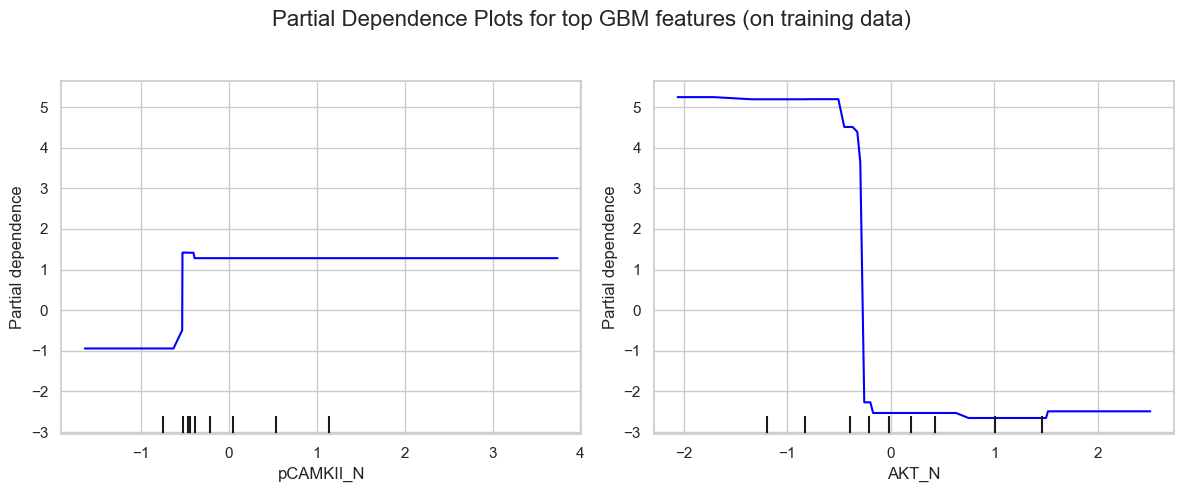

In [16]:
# Plotting partial dependence (spline plots) for top features from GAM using pygam's partial_dependence
if gam_model_fit is not None and len(gam_feature_names_for_fit) > 0:
    print("\nPartial Dependence (Spline) Plots for GAM (selected features):")
    n_plot = min(3, len(gam_feature_names_for_fit))
    fig, axes = plt.subplots(1, n_plot, figsize=(min(18, 5*n_plot), 5))
    if n_plot == 1:
        axes = [axes]

    for i in range(n_plot):
        XX = gam_model_fit.generate_X_grid(term=i)
        pdep = gam_model_fit.partial_dependence(term=i, X=XX)
        axes[i].plot(XX[:, 0], pdep, color='b')
        axes[i].set_title(f"Spline for {gam_feature_names_for_fit[i]}")
        axes[i].set_xlabel(gam_feature_names_for_fit[i])
        axes[i].set_ylabel("Partial Dependence")
    fig.suptitle('GAM Spline Plots for Top Features', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print("GAM spline plots not shown as no features were selected or GAM not fitted.")

# Plotting partial dependence for top 2 features from GBM fitted on X_train
if len(top10_gb_features) > 0:
    print("\nPartial Dependence Plots for Gradient Boosting (top 2 features from training split model):")
    gb_pdp_feature_indices_plot = [protein_cols.index(name) for name in top10_gb_features.index[:min(2, len(top10_gb_features))]]
    n_pdp_gb = len(gb_pdp_feature_indices_plot)
    if n_pdp_gb > 0:
        fig_gb, axes_gb = plt.subplots(1, n_pdp_gb, figsize=(6*n_pdp_gb, 5), squeeze=True)
        if n_pdp_gb == 1:
            axes_gb = [axes_gb]
        PartialDependenceDisplay.from_estimator(
            gb_model_fit,
            X_train,
            features=gb_pdp_feature_indices_plot,
            feature_names=protein_cols,
            ax=axes_gb,
            line_kw={"color": "blue"}
        )
        fig_gb.suptitle('Partial Dependence Plots for top GBM features (on training data)', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
else:
    print("GBM partial dependence plots not shown as no top features were identified.")


**Interpretation of PDPs**: If the PDPs show non-flat, non-linear curves, it provides evidence that the model (GBM or GAM) has learned and is leveraging non-linear relationships for those features. The GAM summary (if `gam_model_fit.summary()` was called) would also indicate the effective degrees of freedom for each spline, where values > 1 suggest non-linearity.

 #### 4. Is there evidence for important interactions between variables?
 * **Gradient Boosting**: GBMs are adept at capturing interactions between features since decision trees naturally model them. If GBM significantly outperforms LASSO and the main-effects GAM (which doesn't explicitly model interactions unless terms like `te(X1,X2)` are added), this could suggest that feature interactions are important for predicting Treatment.
 * **LASSO & Main-Effects GAM**: These models, as implemented here, primarily capture main effects. They do not inherently model interactions unless interaction terms are manually engineered and included.

 The relative CV AUC scores will be the primary guide. If GBM is the top performer by a notable margin, it's plausible that its ability to model both non-linearities and interactions contributes to this success.


## 3. Evaluate Memantine's Effect on Protein Levels in Trisomic, Stimulated Mice
 This section investigates whether Memantine treatment induces specific changes in protein expression levels in the subgroup of trisomic mice (Genotype='Ts65Dn') that were stimulated to learn (Behavior='C/S'). This involves statistical testing for differences in mean protein expression between Memantine and Saline groups within this specific cohort, with appropriate correction for multiple comparisons.


In [18]:
# Filter the DataFrame for the relevant subgroup
subset_df = df[(df['Genotype'] == 'Ts65Dn') & (df['Behavior'] == 'C/S')].copy()
print(f"Number of samples in the subset (Ts65Dn, C/S): {subset_df.shape[0]}")
print("\nTreatment distribution in this subset:")
print(subset_df['Treatment'].value_counts())

# Perform t-tests for each protein
p_values_q3 = []
protein_names_q3 = []
mean_differences_q3 = []

mem_group_q3 = subset_df[subset_df['Treatment'] == 'Memantine'][protein_cols]
sal_group_q3 = subset_df[subset_df['Treatment'] == 'Saline'][protein_cols]

if mem_group_q3.shape[0] < 2 or sal_group_q3.shape[0] < 2: # Need at least 2 samples per group for t-test
    print("\nNot enough samples in one or both treatment groups in the subset for robust t-tests.")
else:
    for protein in protein_cols:
        mem_data = mem_group_q3[protein].dropna()
        sal_data = sal_group_q3[protein].dropna()

        # Ensure sufficient data points in each group for the specific protein
        if len(mem_data) >= 2 and len(sal_data) >= 2:
            t_stat, p_val = ttest_ind(mem_data, sal_data, nan_policy='omit', equal_var=False) # Welch's t-test (unequal variance)
            p_values_q3.append(p_val)
            protein_names_q3.append(protein)
            mean_differences_q3.append(mem_data.mean() - sal_data.mean())
        # else:
            # print(f"Skipping t-test for {protein} in Q3 due to insufficient data.")
            pass

if not protein_names_q3:
    print("No proteins were eligible for t-tests in Q3 due to insufficient data in subgroups after dropping NaNs.")
else:
    # Apply False Discovery Rate (FDR) correction (Benjamini-Hochberg)
    reject_q3, pvals_corrected_q3, _, _ = smm.multipletests(p_values_q3, alpha=0.05, method='fdr_bh')

    results_q3_df = pd.DataFrame({
        'Protein': protein_names_q3,
        'Mean_Difference (Memantine - Saline)': mean_differences_q3,
        'P_Value': p_values_q3,
        'FDR_Corrected_P_Value': pvals_corrected_q3,
        'Significant_FDR_0.05': reject_q3
    })
    results_q3_df = results_q3_df.sort_values(by='FDR_Corrected_P_Value')
    print("\nResults of t-tests for protein expression differences in Ts65Dn, C/S mice:")
    print(results_q3_df.head(10))

    significant_proteins_q3 = results_q3_df[results_q3_df['Significant_FDR_0.05']]
    if not significant_proteins_q3.empty:
        print(f"\nNumber of proteins significantly different (FDR < 0.05): {len(significant_proteins_q3)}")
        print("Significantly different proteins:")
        print(significant_proteins_q3)

        # Optional: Visualize significant proteins
        print("\nVisualizing top 3 significantly different proteins (if any):")
        top_significant_proteins = significant_proteins_q3.head(3)['Protein'].tolist()
        if top_significant_proteins:
            plt.figure(figsize=(15, 5))
            for i, protein in enumerate(top_significant_proteins):
                plt.subplot(1, len(top_significant_proteins), i + 1)
                sns.boxplot(x='Treatment', y=protein, data=subset_df)
                plt.title(f'{protein} Expression by Treatment\n(Ts65Dn, C/S Subset)')
                plt.ylabel('Expression Level')
            plt.tight_layout()
            plt.show()
        else:
            print("No significant proteins to visualize.")
    else:
        print("\nNo proteins showed a statistically significant difference in expression between Memantine and Saline treated mice (FDR < 0.05) in the Ts65Dn, C/S subset.")


Number of samples in the subset (Ts65Dn, C/S): 16

Treatment distribution in this subset:
Treatment
Memantine    9
Saline       7
Name: count, dtype: int64

Results of t-tests for protein expression differences in Ts65Dn, C/S mice:
        Protein  Mean_Difference (Memantine - Saline)   P_Value  \
47         S6_N                             -0.111108  0.008533   
42       NUMB_N                             -0.035408  0.006029   
64  Ubiquitin_N                             -0.109289  0.046470   
63       SNCA_N                             -0.020223  0.047628   
6       pBRAF_N                              0.020698  0.029517   
57      GluR3_N                              0.030353  0.050863   
55        Tau_N                             -0.026981  0.046760   
33        P38_N                              0.033889  0.077750   
43      P70S6_N                             -0.093089  0.095699   
46       CDK5_N                             -0.027072  0.093964   

    FDR_Corrected_P_Value  Sig

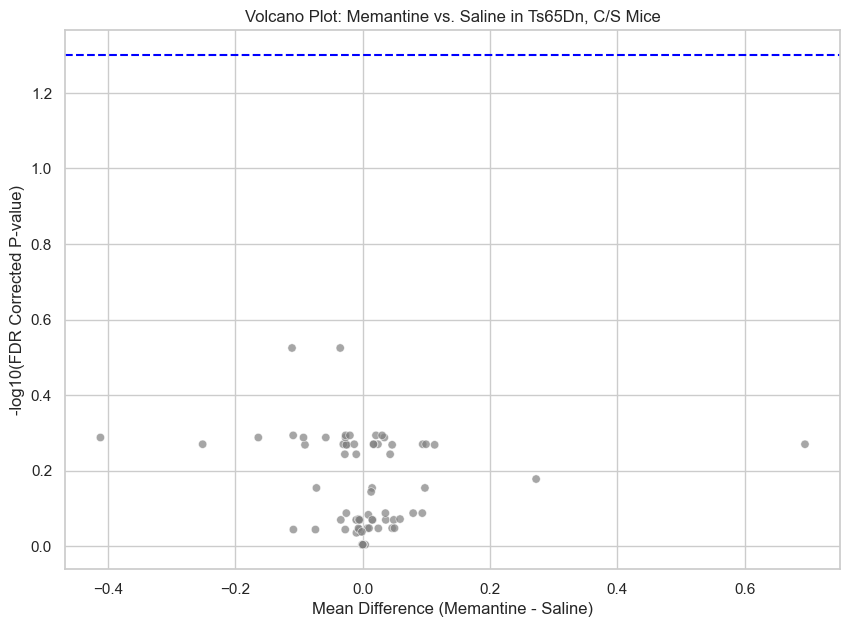

In [19]:
        # Volcano plot for Q3 results
        # Ensure pvals_corrected_q3 is not empty before log10
        if pvals_corrected_q3.size > 0:
            log10_fdr_pvals_q3 = -np.log10(pvals_corrected_q3)
            # Handle potential -inf if p_corrected is 1, or inf if p_corrected is 0
            log10_fdr_pvals_q3[np.isinf(log10_fdr_pvals_q3) & (pvals_corrected_q3 == 0)] = np.nanmax(log10_fdr_pvals_q3[np.isfinite(log10_fdr_pvals_q3)]) + 1 # Replace inf with a large value
            log10_fdr_pvals_q3[np.isinf(log10_fdr_pvals_q3) & (pvals_corrected_q3 == 1)] = 0 # Replace -inf with 0


            volcano_q3_df = pd.DataFrame({
                'Protein': protein_names_q3,
                'Mean_Difference': mean_differences_q3,
                'neg_log10_FDR_Pval': log10_fdr_pvals_q3,
                'Significant': reject_q3
            })

            plt.figure(figsize=(10, 7))
            sns.scatterplot(
                x='Mean_Difference', 
                y='neg_log10_FDR_Pval', 
                data=volcano_q3_df, 
                hue='Significant', 
                palette={True: 'red', False: 'grey'},
                alpha=0.7
            )
            plt.axhline(-np.log10(0.05), color='blue', linestyle='--', label='FDR = 0.05 Threshold')
            # Optional: add lines for effect size thresholds if meaningful
            # plt.axvline(1, color='orange', linestyle='--', label='Effect Size = +1')
            # plt.axvline(-1, color='orange', linestyle='--')
            plt.title('Volcano Plot: Memantine vs. Saline in Ts65Dn, C/S Mice')
            plt.xlabel('Mean Difference (Memantine - Saline)')
            plt.ylabel('-log10(FDR Corrected P-value)')
            if volcano_q3_df['Significant'].any():
                 plt.legend(title='Significant (FDR < 0.05)')
            else:
                 plt.legend().remove()
            plt.show()
        else:
            print("Volcano plot not generated for Q3 as no proteins were tested or p-values were problematic.")